# <center>  Assignment 1 - Toronto Bike Share  </center>
### <center> Karl Hendrik Nurmeots </center>
<center>  February 3, 2020 </center>


***

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import seaborn as sns
import re

In [41]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

This report aims to analyze how Toronto Bike Share customer behaviour is affected by various parameters. More precisely, we will take a look at how trip length is affected by these factors.

We will aim to answer the following questions:

- How can we measure the 'length' of trips?
- How are these different definitions of 'length' related to each other?
- Is trip 'length' different for customers who are regular members vs. those who use a temporary pass?
- How do the present season or weather conditions affect trip 'length'?

This report takes some inspiration from the report [Exploring Toronto Bike Share Ridership using Python](https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62), written by Yizhao Tan.

# Data

This report uses official [Toronto Bike Share ridership data](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/) from Q3 and Q4 of 2016, and the entirety of 2017. To accompany this, we will also use [Bike Share station information](https://open.toronto.ca/dataset/bike-share-toronto/). We will scrape the weather data from the [Government of Canada historical climate database](https://climate.weather.gc.ca/).

Per the [terms and conditions of canada.ca](https://www.canada.ca/en/transparency/terms.html), we are permitted to scrape the data for non-commercial use as long as we:
> - exercise due diligence in ensuring the accuracy of the materials reproduced
> - indicate both the complete title of the materials reproduced, as well as the author (where available)
> - indicate that the reproduction is a copy of the version available at [URL where original document is available]

Use of this data for commercial purposes is not allowed without special permission. We will be sure to adhere to these requirements for this report.

### Toronto Bike Share Data

First, let us take a look at the Bike Share data.

In [42]:
# Reading in the data.
q1_2017 = pd.read_csv("Bikeshare Ridership (2017 Q1).csv")
q2_2017 = pd.read_csv("Bikeshare Ridership (2017 Q2).csv")
q3_2017 = pd.read_csv("Bikeshare Ridership (2017 Q3).csv")
q4_2017 = pd.read_csv("Bikeshare Ridership (2017 Q4).csv")
q3_2016 = pd.read_excel("bikeshare-ridership-2016-q3.xlsx")
q4_2016 = pd.read_excel("bikeshare-ridership-2016-q4.xlsx")

In [43]:
q1_2017.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
0,712382,1/1/2017 0:00,1/1/2017 0:03,223,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member
1,712383,1/1/2017 0:00,1/1/2017 0:05,279,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member
2,712384,1/1/2017 0:05,1/1/2017 0:29,1394,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member
3,712385,1/1/2017 0:07,1/1/2017 0:21,826,7077,College Park South,7010,King St W / Spadina Ave,Member
4,712386,1/1/2017 0:08,1/1/2017 0:12,279,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member


In [44]:
q3_2016.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
0,53279,2016-07-09 01:03:00,2016-07-09 01:15:00,714,Dundas St E / Regent Park Blvd,Danforth Ave / Ellerbeck St,Member
1,53394,2016-07-09 02:15:00,2016-07-09 02:22:00,417,Riverdale Park North (Broadview Ave),Dundas St E / Regent Park Blvd,Member
2,58314,2016-07-10 17:04:00,2016-07-10 17:36:00,1904,Dundas St E / Regent Park Blvd,Queen St W / Close Ave,Member
3,60784,2016-07-11 01:45:00,2016-07-11 01:58:00,784,Union Station,Dundas St E / Regent Park Blvd,Member
4,93164,2016-07-18 13:35:00,2016-07-18 13:42:00,443,Front St W / Blue Jays Way,Front St / Yonge St (Hockey Hall of Fame),Member


Above are shown the first couple of rows in the Q1 2017 and Q3 2016 datasets respectively. The datasets contain the following variables:

`trip_id`: unique identifier for each trip. <br>
`trip_start_time`: date and time of the beginning of the trip.<br>
`trip_stop_time`: date and time of the end of the trip.<br>
`trip_duration_seconds`: the duration of the trip in seconds.<br>
`from_station_name`: the name of the station where the trip began from.<br>
`to_station_name`: the name of the station where the trip ended.<br>
`user_type`: shows whether the user has a Bike Share membership or purchased a temporary pass.<br>

Note that the Q1 2017 dataset also contains the variables `to_station_id` and `from_station_id`, which are not present in the Q3 2016 dataset. Hence, once we get to working with the data, we will omit these columns from the databases they are present in.

There are also several other inconsistencies and issues with the data: note how the trip start and end times are formatted differently in the datasets. We will have to standardize this.

Furthermore, in the data there are strangely short trips that start and end at the same station:

In [45]:
q4_2017.loc[363400:363404:3]

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
363400,2383642,12/31/17 23:46:27,12/31/17 23:46:53,26,Bloor St / Brunswick Ave,Bloor St / Brunswick Ave,Casual
363403,2383645,12/31/17 23:49:08,12/31/17 23:49:34,26,Phoebe St / Spadina Ave,Phoebe St / Spadina Ave,Member


Toronto Bike Share considers valid trips to be those that are at least 60 seconds long, so we will exclude trips shorter than this from our analysis. In total, there are nearly 13 000 trips that start and end at the same station, but bare in mind that many of these could be valid trips.

Finally, we will also exclude any trips with missing data, and combine all of the separate datasets into a single big one.

In [46]:
# Drop the station ID information 
q1_2017 = q1_2017.drop(columns = ['from_station_id', 'to_station_id'])
q2_2017 = q2_2017.drop(columns = ['from_station_id', 'to_station_id'])

# Create the combined dataframe
df = pd.concat([q3_2016, q4_2016, q1_2017, q2_2017, q3_2017, q4_2017], ignore_index=True)
# Convert the trip start and stop times to datetime objects
df["trip_start_time"] = pd.to_datetime((df["trip_start_time"]), errors = 'coerce')
df["trip_stop_time"] = pd.to_datetime((df["trip_stop_time"]), errors = 'coerce')
# Remove trips shorter than 60 seconds
df = df[df.trip_duration_seconds >= 60]

In [47]:
# Remove trips with missing data
df = df.dropna()

We will create a new column named `season`, representing the season (winter, spring, summer, autumn) the trip took place in based on the month the trip took place on.

In [48]:
def get_season(row):
    """Takes in a pandas Series representing info about a trip, and returns the season the 
    trip took place in."""
    month = int(row.trip_start_time.strftime('%m'))
    if month in [12, 1, 2]: 
        return 'winter'
    elif month in [3, 4, 5]: 
        return 'spring'
    elif month in [6, 7, 8]: 
        return 'summer'
    else: 
        return 'autumn'

df['season'] = df.apply(lambda row: get_season(row), axis=1)

We will go into more detail about this later, but we also would like to find out what is the physical distance between the start and end stations. To do so, we will use the Bike Share stations data and use their coordinates.

The coordinates are represented in WGS longitude and latitude, so we can use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute the distance between two stations. Conveniently, a Python package called haversine exists just for this purpose. We will store trip distance in meters in a new variable named `trip_distance`.

In [49]:
# Read in the data
stations = pd.read_json('station_information.json')['data'][0]

# Create dictionary mapping station names to their latitude and longitude,
# this will be used as a lookup dictionary
coordinates = {}
for station in stations:
    if station['name'] not in coordinates:
        coordinates[station['name']] = (station['lat'], station['lon'])
        
def get_trip_distance(row):
    """Takes in a pandas Series representing information about a trip, and returns
    the distance between the start and end stations as the crow flies in meters.
    If coordinates data is not available for a station, the function returns NaN."""
    
    if not (row.from_station_name in coordinates and row.to_station_name in coordinates):
        return np.nan
    start = (coordinates[row.from_station_name][0], coordinates[row.from_station_name][1])
    end = (coordinates[row.to_station_name][0], coordinates[row.to_station_name][1])
    return haversine(start, end, unit='m')

df['trip_distance'] = df.apply(lambda row: get_trip_distance(row), axis=1)

It turns out that there are many inconsistensies with the station names, too. For example, a station name can be represented both as 'Lake Shore Blvd' and 'Lakeshore Blvd'. This is a big problem: when computing distances between stations, we were unable to do so for nearly 800 000 trips - about 40% of our dataset. We are still left with data for over a million trips, which is sufficient for our analysis, so we will not try to correct this issue. 

We can take a look at where trip distance is missing with regard to the time period the trip is in:

In [50]:
# Create df consisting of trips with NaN trip_distance, find the period each trip is from
missing = df[df.isna().any(axis=1)]
# missing['quarter'] = missing['trip_start_time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
# missing['year'] = pd.DatetimeIndex(missing['trip_start_time']).year
# missing['period'] = missing.apply(lambda row: "Q"+str(row.quarter) + " " + str(row.year), axis=1)

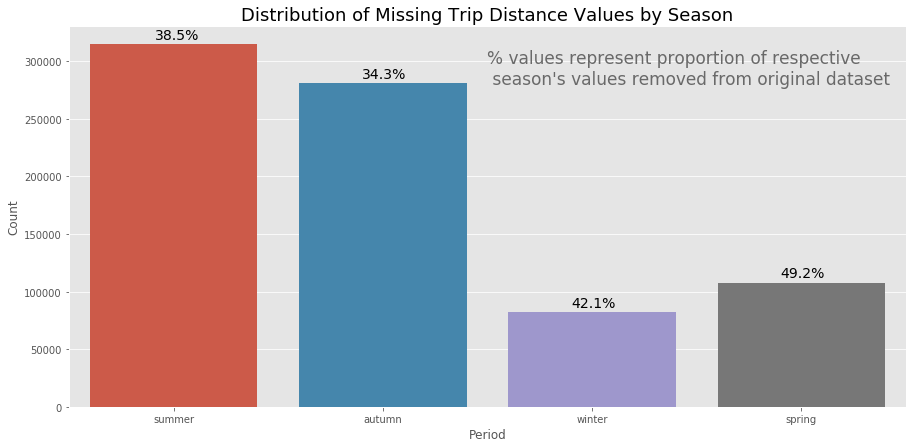

In [113]:
sns.countplot(x=missing.season)

# Calculate and plot % for what proportion of season's data is being removed
plt.text(-0.09, len(missing[missing.season == 'summer'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'summer'].index)*100/len(df[df.season == 'summer'].index), 1)),
        fontsize=14)

plt.text(0.9, len(missing[missing.season == 'autumn'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'autumn'].index)*100/len(df[df.season == 'autumn'].index), 1)),
        fontsize=14)

plt.text(1.9, len(missing[missing.season == 'winter'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'winter'].index)*100/len(df[df.season == 'winter'].index), 1)),
        fontsize=14)

plt.text(2.9, len(missing[missing.season == 'spring'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'spring'].index)*100/len(df[df.season == 'spring'].index), 1)),
        fontsize=14)

plt.text(1.5, 280000, "% values represent proportion of respective\n season's values removed from original dataset",
        fontsize=17, color='dimgrey')

plt.title("Distribution of Missing Trip Distance Values by Season", fontsize=18)
plt.xlabel("Period")
plt.ylabel("Count")
plt.show()

We can see how we are removing more values from trips that took place during summer and autumn, however proportionately we have not taken away as many values from those seasons. Instead, we have disproportionately taken away more values from winter and spring trips.

This is not great because there is a 15% swing in the proportion of values removed from spring and autumn data. However, there is not much we can do: spelling inconsistencies are notoriously difficult to fix, so this limitation is simply something we will have to keep in mind when doing analysis - we will still exclude trips with missing trip distance data from our analysis.

In [114]:
df = df[~df.isna().any(axis=1)]

# Weather Data

We will scrape the data from Canada's historical climate database for each day from July 1st 2016 to December 31st 2017 - the time period we are analysing our Bike Share data on. The data is presented in [neat tables](https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=1#) that are really easy and fast to go through using Pandas. We will scrape each day's mean temperature in degrees Celcius, and each day's precipitation as a boolean value, representing whether there was any during the day or not.

First, we will create a dictionary of the form:

```python
    {YEAR:
        {DAY: (mean_temp, precipitation)
        }
    }
```

Data is not available for all days, in which case we will input the appropriate value as NaN.

In [218]:
weather = {2016: {}, 2017: {}}

# For each month in 2016, make a query
for month in range(7,13):
    weather[2016][month] = {}
    
    url = 'https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2016&Month={}#'\
          .format(month)
    table = pd.read_html(url)[0]
    
    # Iterate through table for given month
    for i, row in table.iterrows():
        # If we are no longer reading day data, but instead a row like 'sum'
        if re.search("^\d{2}$", row['DAY']) is None:
            break
        
        # When the month's table has no unexpected values, they are stored immediatelly as floats,
        # so to standardize our method, we will first cast every value as a str
        mean_temp = str(row['Mean Temp Definition°C'])
        precipitation = str(row['Total Precip Definitionmm'])
        
        # Check that we have data for the given day
        if re.search("\d\.\d$", mean_temp) is None:
            mean_temp = np.nan
        else:
            mean_temp = float(mean_temp)
            
        if re.search("\d\.\d$", precipitation) is None:
            precipitation = np.nan
        elif float(precipitation) > 0:
            precipitation = True
        else:
            precipitation = False
        
        # Store as tuple containing mean temperature and precipitation
        weather[2016][month][int(row['DAY'])] = (mean_temp, precipitation)
        
# For each month in 2017, make a query
for month in range(1,13):
    weather[2017][month] = {}
    
    url = 'https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month={}#'\
          .format(month)
    table = pd.read_html(url)[0]
    
    # Iterate through table for given month
    for i, row in table.iterrows():
        # If we are no longer reading day data, but instead a row like 'sum'
        if re.search("^\d{2}$", row['DAY']) is None:
            break
        
        # When the month's table has no unexpected values, they are stored immediatelly as floats,
        # so to standardize our method, we will first cast every value as a str
        mean_temp = str(row['Mean Temp Definition°C'])
        precipitation = str(row['Total Precip Definitionmm'])
        
        # Check that we have data for the given day
        if re.search("\d\.\d$", mean_temp) is None:
            mean_temp = np.nan
        else:
            mean_temp = float(mean_temp)
            
        if re.search("\d\.\d$", precipitation) is None:
            precipitation = np.nan
        elif float(precipitation) > 0:
            precipitation = True
        else:
            precipitation = False
        
        # Store as tuple containing mean temperature and precipitation
        weather[2017][month][int(row['DAY'])] = (mean_temp, precipitation)

Then, we iterate through our entire Bike Share dataframe, and get the mean temperature and precipitation data for each trip from our lookup dictionary. We will store the mean temperature in `mean_temp` and whether there was any precipitation in `precipitation`.

In [224]:
def get_weather_statistics(row):
    """Takes in a pandas Series representing information about a single trip, and returns
    the mean temperature and precipitation of the day the trip took place (more precisely,
    the day the trip began on)."""
    # Get the trip's year, month and day, and then look up the value in the dictionary
    year = int(row.trip_start_time.strftime('%Y'))
    month = int(row.trip_start_time.strftime('%m'))
    day = int(row.trip_start_time.strftime('%d'))
    
    if year not in weather or month not in weather[year] or day not in weather[year][month]:
        return pd.Series((np.nan, np.nan))
    
    data = weather[year][month][day]
    if len(data) != 2:
        return pd.Series((np.nan, np.nan))

    return pd.Series(data)

df[['mean_temp', 'precipitation']] = df.apply(lambda row: get_weather_statistics(row), axis=1)

Now, let's take a quick glance at how these newly created variables distribute. First, `mean_temp`:

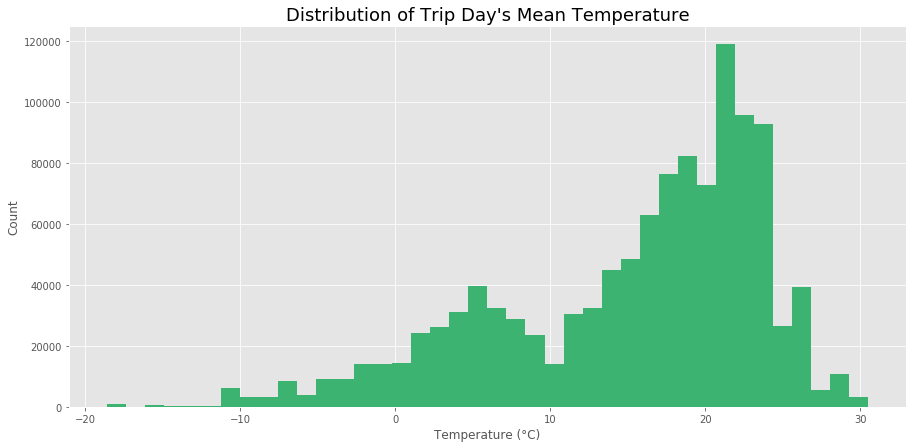

In [239]:
df['mean_temp'].hist(bins=40, color='mediumseagreen')

plt.title("Distribution of Trip Day's Mean Temperature", fontsize=18)
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.show()

In [240]:
desc = {"Trip day's mean temperature (°C)": df.mean_temp.describe().round(1)}
pd.DataFrame(desc)

,Trip day's mean temperature (°C)
count,1152407.0
mean,15.3
std,8.6
min,-18.6
25%,9.1
50%,17.7
75%,21.9
max,30.5


We can see that the distribution has two dominant modes: one centered around 20°C, and the other around 5°C. The distribution is left-skewed with an overall mean temperature of 15°C.

Secondly, `precipitation`:

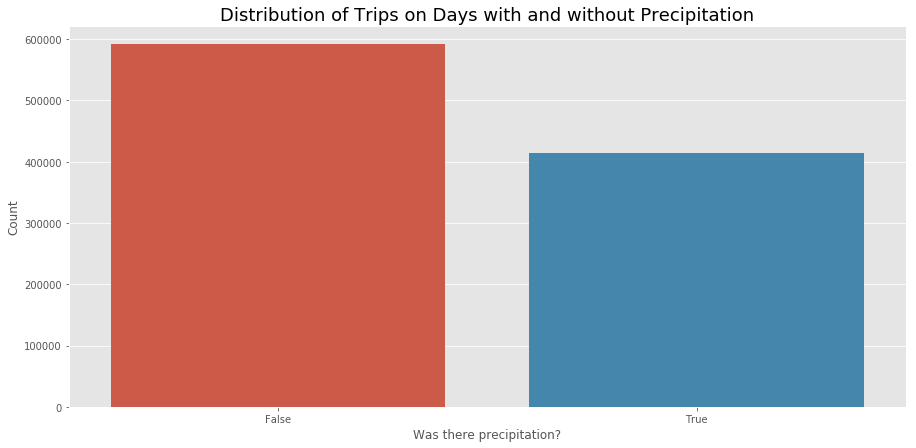

In [238]:
sns.countplot(x=df.precipitation)

plt.title("Distribution of Trips on Days with and without Precipitation", fontsize=18)
plt.xlabel("Was there precipitation?")
plt.ylabel("Count")
plt.show()

We can see that about 50% more trips have been recorded on days without precipitation.

# Analysis
## 1. Measuring trip 'length'

We will consider two ways to measure trip length. First, we can measure the duration of the trip in seconds by using the information in `trip_duration_seconds` that came with the original dataset.

Secondly, we can measure the distance between the trip's start and end stations 'as the crow flies'. Of course, since bikes can't fly nor go through buildings, this trajectory will likely not represent the actual path a customer took. Because we don't have any tracking data, nor do we have a simple way to figure out the most probable shortest path the customer took, this method is the best available measurement of trip distance. It is very likely that a lot of users don't simply ride from station A to station B, but instead take detours and stop in different places inbetween, too. Despite these limitations, it still gives us some sort of idea on how long the trip was.

As mentioned previously, we have coordinates data for the bike stations, so we've used the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute the distance between the start and end stations in meters, and stored it in the column `trip_distance`.

Let's now dive into the data and take a look at how these two measurements distribute. First, we will look at `trip_duration_seconds`. We will immediatelly realise that this distribution has some extreme outliers, which are clearly visible on this strip plot:

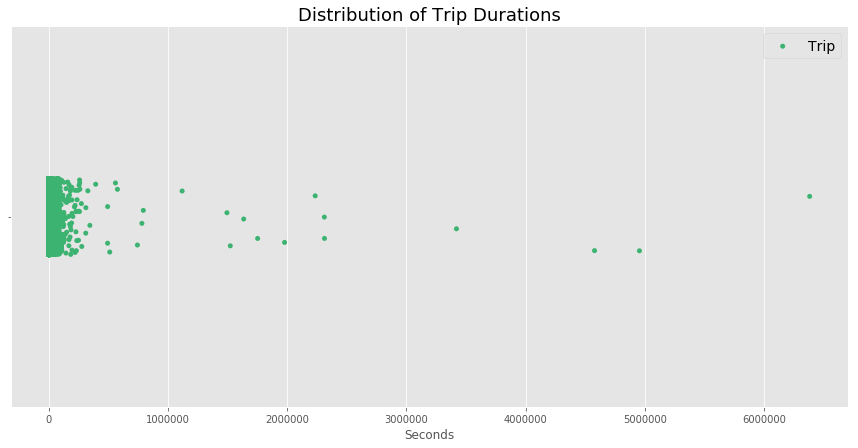

In [115]:
sns.stripplot(x=df.trip_duration_seconds, size = 5, jitter=True, label='Trip', color='mediumseagreen')

plt.title("Distribution of Trip Durations", fontsize=18)
plt.xlabel("Seconds")
plt.legend(fontsize=14)
plt.show()

The longest trip recorded in this dataset is nearly 72 days long - that's over 2 months! Unless Forrest Gump gave up running and decided instead to pick up biking, it is safe to say that these outliers are invalid trips. 

We will need to somehow deal with these outliers, but it is difficult to intuitively draw a hard line on how long a valid trip can be. Hence, we will use the commonly accepted definition that defines outliers as points that are at least 1.5 times the length of the inner-quartile range (IQR) away from either end of the IQR.

In [116]:
def remove_outliers(df):
    """Removes all rows for which the entry in trip_duration_seconds is more than 1.5 times the length
    of the inner quartile range (IQR) away from the first or third quartiles of the distribution of
    the trip durations."""
    
    first = df.trip_duration_seconds.quantile(0.25)
    third = df.trip_duration_seconds.quantile(0.75)
    iqr = third - first
    return df[(first - 1.5*iqr <= df.trip_duration_seconds) & (df.trip_duration_seconds <= third + 1.5*iqr)]

df = remove_outliers(df)

We can't say for sure that we aren't eliminating valid trips - there might be people who just decided to go on really long trips, but we have to draw a line somehow. Intuitively, we wouldn't expect anyone to use a bike for more than a short period of time, so under this assumption we won't remove many valid trips, which in return will not skew any of our later analyses. We can now take a look at how trip duration distributes:

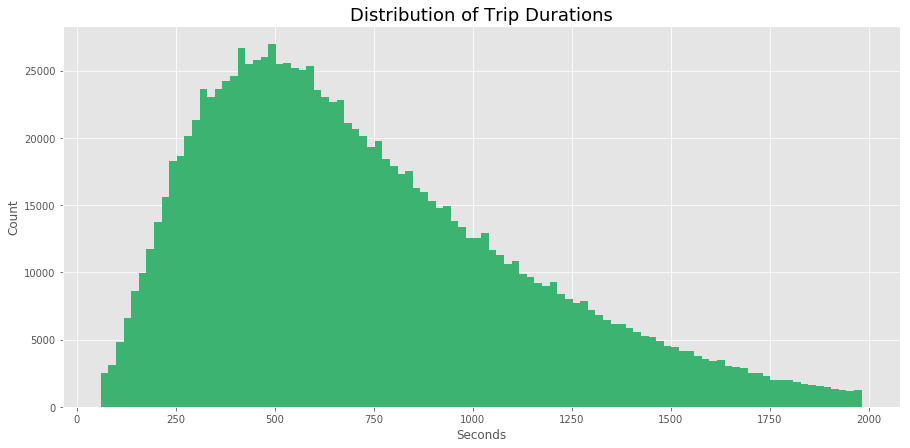

In [117]:
df.trip_duration_seconds.hist(bins=100, color='mediumseagreen')

plt.title("Distribution of Trip Durations", fontsize=18)
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

In [118]:
desc = {'Trip Duration (seconds)': df.trip_duration_seconds.describe().round(1)}
pd.DataFrame(desc)

,Trip Duration (seconds)
count,1187934.0
mean,728.6
std,398.1
min,60.0
25%,423.0
50%,650.0
75%,969.0
max,1982.0


After all of our data cleaning we are left with just under 1.2 million trips. We can clearly see how our changes have cut the distribution at 60 seconds, and at 1982 seconds - that is 33 minutes, which is where from onwards we consider trips to be outliers. The average trip duration is 728 seconds or just over 12 minutes. The distribution is unimodal with a mode at around 500 seconds or 8 minutes, and is right-skewed.

Now, let's take a look at `trip_distance`:

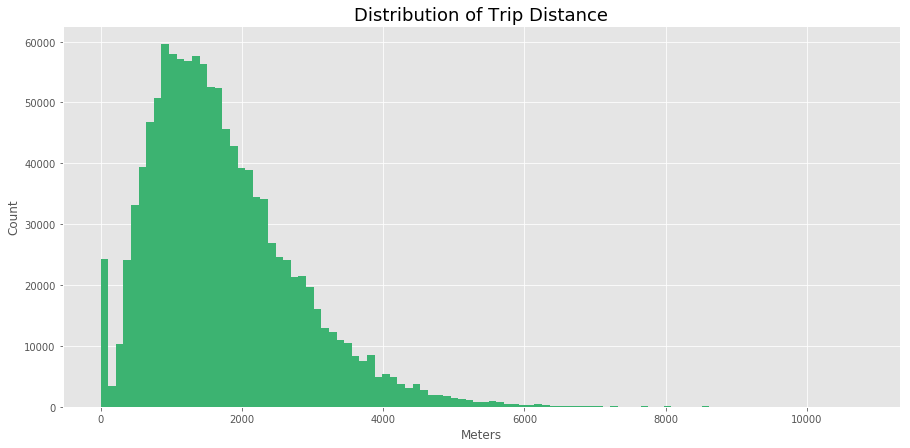

In [119]:
df.trip_distance.hist(bins=100, color='mediumseagreen')

plt.title("Distribution of Trip Distance", fontsize=18)
plt.xlabel("Meters")
plt.ylabel("Count")
plt.show()

In [120]:
desc = {'Trip Distance (meters)': df.trip_distance.describe().round(1)}
pd.DataFrame(desc)

,Trip Distance (meters)
count,1187934.0
mean,1728.3
std,1030.8
min,0.0
25%,977.9
50%,1540.2
75%,2286.7
max,10773.6


In terms of shape, we can immediately see that this distribution is similar to trip duration's distribution - it is also unimodal and right-skewed. Another interesting thing to notice is the outsticking high bin on the very left - this represents the trips which started and ended at the same station. As hypothesised earlier, we can now fairly safely say that there are valid round trips starting and beginning at the same station as we've done our best to remove any invalid entries. Similarly, it is interesting to see how the longest trip has been at least 10.7 kilometers long (recall that this is only the straight line distance).

We can look at the relationship between our two measurements of trip length. As one would expect, it takes a longer amount of time to cover a longer distance. However, as has been mentioned on numerous occasions already, there are many things we can't see from just the start and end stations - were there any stops or detours inbetween, or did the rider take the optimal path.

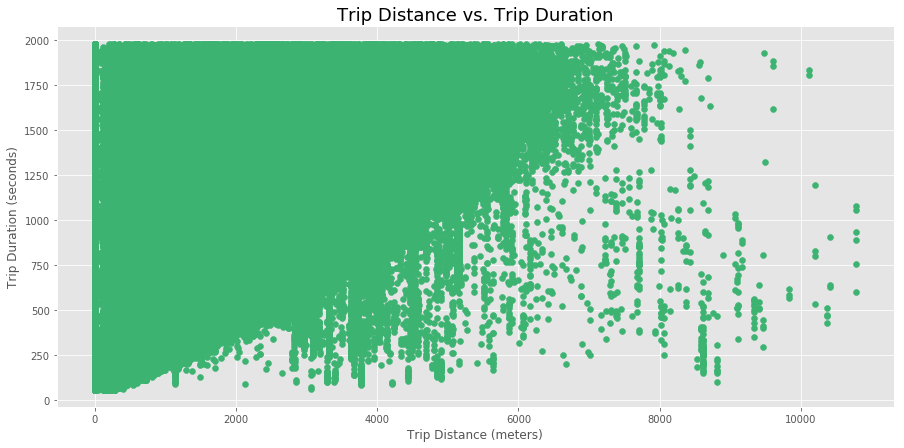

In [121]:
fig, ax = plt.subplots()

ax.scatter(x=df.trip_distance, y=df.trip_duration_seconds, color='mediumseagreen')

plt.title("Trip Distance vs. Trip Duration", fontsize=18)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Trip Duration (seconds)")
plt.show()

Boy, what a mess, but an interesting one! To get a better idea of what's going on, let's pair this graph with the exact same one, but let's make every dot partially transparent to better visualize the clustering.

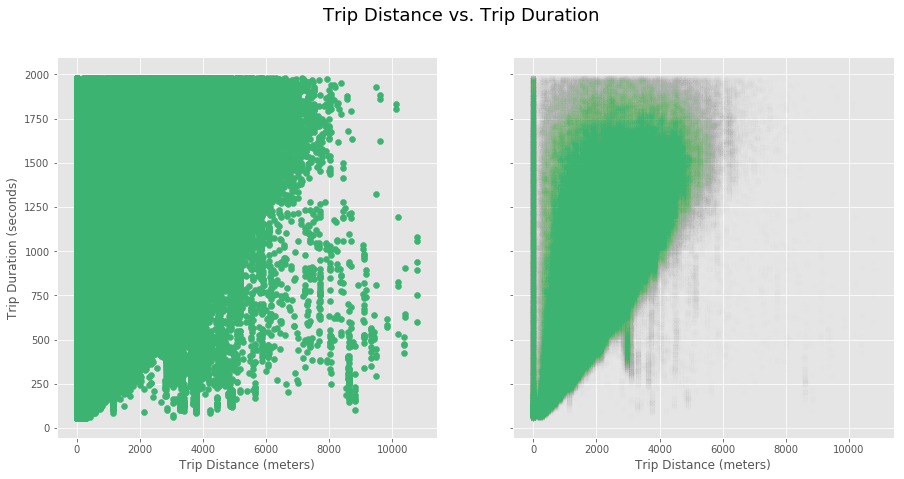

In [122]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.trip_distance, y=df.trip_duration_seconds, color='mediumseagreen')
ax[1].scatter(x=df.trip_distance, y=df.trip_duration_seconds, color='mediumseagreen', alpha=0.002)

plt.suptitle("Trip Distance vs. Trip Duration", fontsize=18)
ax[0].set_xlabel("Trip Distance (meters)")
ax[1].set_xlabel("Trip Distance (meters)")
ax[0].set_ylabel("Trip Duration (seconds)")
plt.show()

We can see how the data has, as expected, a lot of variance, but still we can notice a sort of exponential relationship between trip distance and duration, which matches intuition: on longer trips people become tired and so can't cycle as fast and may have to take breaks. We can again notice the trips starting and ending at the same station and see that people go on trips of very various durations of such type.

There's a very interesting outsticking cluster of trips around the 3000 meter - 500 second mark, but it is difficult to find a good explanation for it. Perhaps this is the effect of a popular route between two stations: users travel between these two stations often and with the same average time, causing it to appear on this visualization.

Once again we realise that there are anomalies in the data: notice some of the outliers in the bottom right corner. Some of these trips show as having completed around 10 000 meters in 500 seconds, that amounts to an average speed of 72 km/h - that is absolutely inhumane. [The fastest recorded cycling speed in an upright position is 82 km/h](https://en.wikipedia.org/wiki/Bicycle_performance#Typical_speeds) and that is only over a distance of 200 meters, while the [fastest Tour de France time set by Lance Armstrong was achieved with an average speed of 41 km/h](https://www.cyclingweekly.com/news/racing/tour-de-france/fast-tour-de-france-useless-stats-429620), and well, he had some extra help to achieve that, too.

Again, we would like to eliminate these outliers, but drawing a hard line is difficult to do. We can't use the 'IQR trick' on trip speed this time because, as previously explained, there are many reasons why the distance travelled may not represent the true value, and so trip speed is affected too. So, we are going to choose a fixed value based on the examples provided previously: we will remove any trips with an average speed over 40 km/h. While it is entirely possible that someone was in that much of a hurry, we are dealing with city bike data, and so it's reasonable to expect such trips to be invalid. When we graph our cutoff line, we see that we aren't removing any trips in the main cluster of the data:

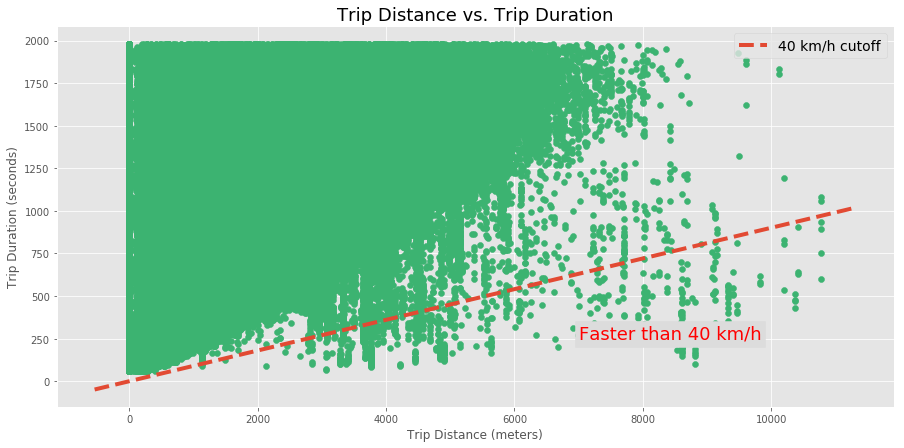

In [123]:
fig, ax = plt.subplots()

ax.scatter(x=df.trip_distance, y=df.trip_duration_seconds, color='mediumseagreen', label="")

# Generate points to plot assuming a speed of 40 km/h = 11.1 m/s
x_vals = np.array(ax.get_xlim())
y_vals = 1/11.1 * x_vals
ax.plot(x_vals, y_vals, '--', linewidth = 4, label = '40 km/h cutoff')

ax.text(7000, 250, "Faster than 40 km/h", color='red', size=18, backgroundcolor='gainsboro')

plt.title("Trip Distance vs. Trip Duration", fontsize=18)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Trip Duration (seconds)")
plt.legend(fontsize=14, loc='upper right')
plt.show()

In [124]:
df = df[df.trip_distance/df.trip_duration_seconds <= 11.1]

## 2. Casual user vs. member behaviour

We will compare how both of our trip length definitions differ when looking at either casual users or members. By casual users we mean customers who purchased a temporary pass to use a bike, rather than purchasing a long-term membership. First, let's consider trip duration.

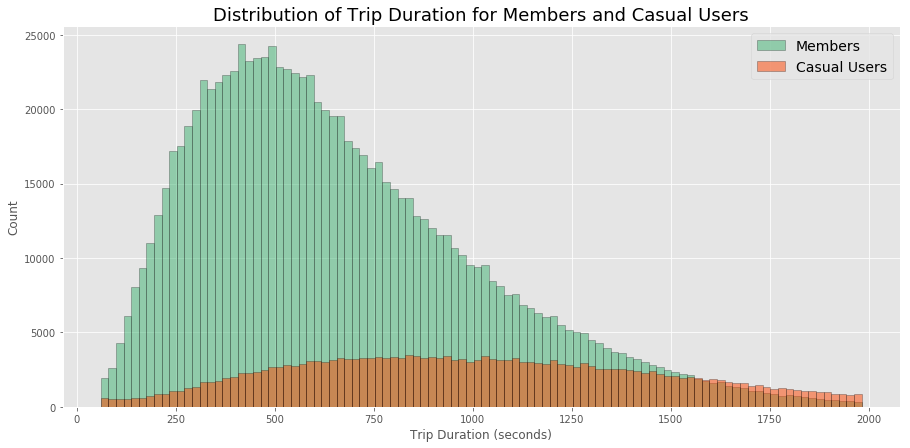

In [125]:
plt.hist(df[df.user_type == 'Member']['trip_duration_seconds'], bins=100, alpha=0.5, edgecolor='black',
        color='mediumseagreen', label='Members')    
plt.hist(df[df.user_type == 'Casual']['trip_duration_seconds'], bins=100, alpha=0.5, edgecolor='black',
        color='orangered', label='Casual Users')

plt.title("Distribution of Trip Duration for Members and Casual Users", fontsize=18)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

In [126]:
desc = {'Members': df[df.user_type == 'Member']['trip_duration_seconds'].describe().round(1),
        'Casual users': df[df.user_type == 'Casual']['trip_duration_seconds'].describe().round(1)}
pd.DataFrame(desc)

,Members,Casual users
count,966135.0,221092.0
mean,666.0,1003.4
std,358.4,443.7
min,60.0,60.0
25%,395.0,658.0
50%,596.0,980.0
75%,874.0,1335.0
max,1982.0,1982.0


The first obvious observation is that the vast majority of trips are made by members. Thus, as would make sense, the shape of the distribution for members looks to be identical to the overall distribution of trip duration that we saw earlier. However, the distribution for non-members is completely different.

The distribution for casual users is fairly symmetrical, with a mean of 1003 seconds or 17 minutes, 50% more than the mean for members. We can notice how very long trips are more common among casual users, which is surprising considering we have more than 4 times the data for members.

Similarly, let's take a look at trip distance:

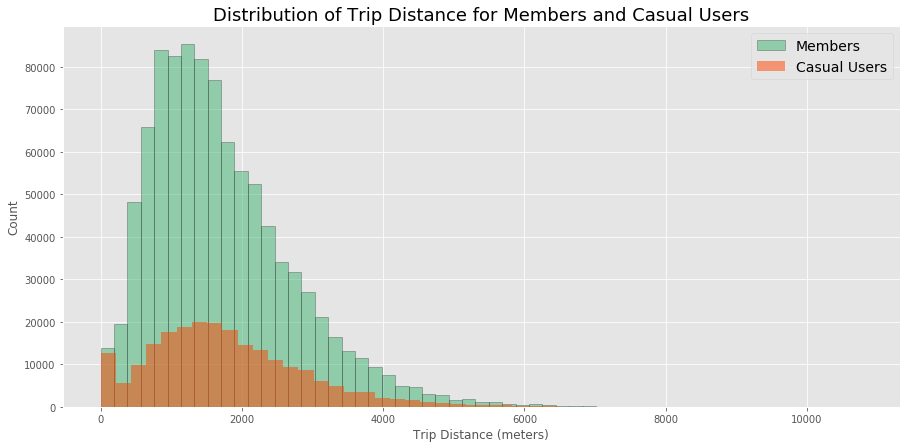

In [127]:
plt.hist(df[df.user_type == 'Member']['trip_distance'], bins=50, alpha=0.5, edgecolor='black',
        color='mediumseagreen', label='Members')    
plt.hist(df[df.user_type == 'Casual']['trip_distance'], bins=50, alpha=0.5,
        color='orangered', label='Casual Users')

plt.title("Distribution of Trip Distance for Members and Casual Users", fontsize=18)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

In [128]:
desc = {'Members': df[df.user_type == 'Member']['trip_distance'].describe().round(1),
        'Casual users': df[df.user_type == 'Casual']['trip_distance'].describe().round(1)}
pd.DataFrame(desc)

,Members,Casual users
count,966135.0,221092.0
mean,1714.4,1777.0
std,1010.3,1090.0
min,0.0,0.0
25%,974.5,1014.7
50%,1520.4,1635.4
75%,2260.0,2394.8
max,9477.0,10773.6


This time we can see that the distributions for members and casual users have a very similar shape, and resemble the shape of the overall distribution for trip distance. Interestingly enough, casual users nearly match members in the number of trips that start and end at the same stop despite there being over 4 times fewer trips recorded by casual users.

Because the distributions for members and casual users were so different for trip duration, but similar for trip distance, we would expect casual users to have slower trip speeds. Let's turn to the already familiar scatterplots we saw to investigate:

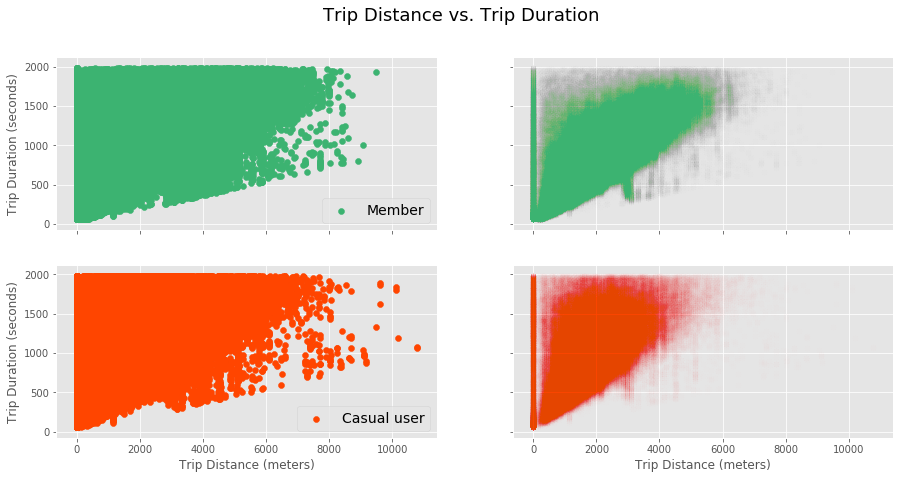

In [129]:
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)

ax[0][0].scatter(x=df[df.user_type == 'Member']['trip_distance'], y=df[df.user_type =='Member']['trip_duration_seconds'],
              color='mediumseagreen', label='Member')
ax[1][0].scatter(x=df[df.user_type == 'Casual']['trip_distance'], y=df[df.user_type =='Casual']['trip_duration_seconds'],
              color='orangered', label='Casual user')
ax[0][1].scatter(x=df[df.user_type == 'Member']['trip_distance'], y=df[df.user_type =='Member']['trip_duration_seconds'],
              color='mediumseagreen', alpha=0.002)
ax[1][1].scatter(x=df[df.user_type == 'Casual']['trip_distance'], y=df[df.user_type =='Casual']['trip_duration_seconds'],
              color='orangered', alpha=0.002)

plt.suptitle("Trip Distance vs. Trip Duration", fontsize=18)
ax[1][0].set_xlabel("Trip Distance (meters)")
ax[1][1].set_xlabel("Trip Distance (meters)")
ax[0][0].set_ylabel("Trip Duration (seconds)")
ax[1][0].set_ylabel("Trip Duration (seconds)")
ax[0][0].legend(fontsize=14)
ax[1][0].legend(fontsize=14)
plt.show()

As hypothesized, casual users seem to have a lower average speed as the main cluster of points representing trips is more towards the top left corner of the graph - less distance covered in greater time. We can also notice how casual users have more outliers compared to members, this is caused by long distance trips being more common among casual users, as we saw before. Again, we can see on both density graphs how there are trips starting and ending at the same time with very various durations.

## 3. Effects of the present season and weather conditions on trip length

In this part we will analyze what sort of effect, if any, do the season and weather have on our two definitions of trip length. To start off, let's look at the effects season has.

Recall that we defined the season the trip took place in based on the trip's month, and stored it in the column `season`. During the data cleaning process we noticed how we removed a disproportionate amount of trips from winter and spring data, so let's first take a look at how our season data distributes:

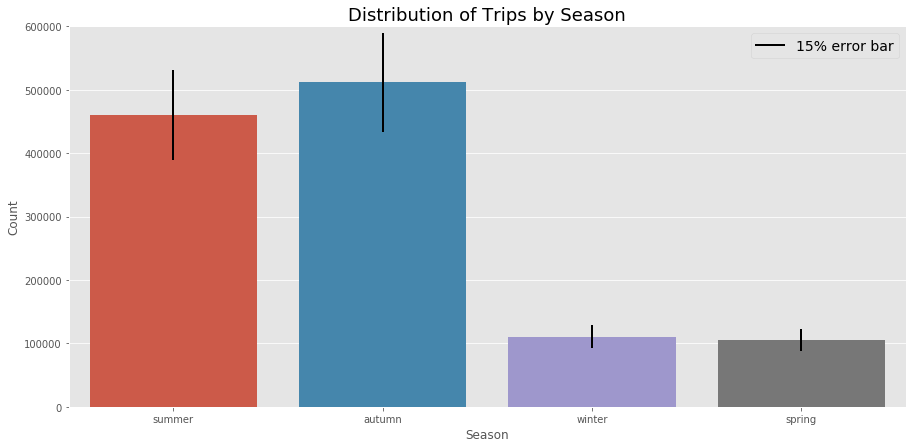

In [164]:
ax = sns.countplot(x=df.season)
ax.set_ylim([0,600000])

# Plot error bars
ax.axvline(x=0,ymin=(len(df[df.season=='summer'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='summer'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black', label='15% error bar')

ax.axvline(x=1,ymin=(len(df[df.season=='autumn'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='autumn'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black')

ax.axvline(x=2,ymin=(len(df[df.season=='winter'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='winter'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black')

ax.axvline(x=3,ymin=(len(df[df.season=='spring'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='spring'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black')

plt.title("Distribution of Trips by Season", fontsize=18)
plt.xlabel("Season")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

We can see how the large majority of trips take place during summer and autumn months - this is clearly the case even when we try to account for the error we might have made previously when removing trips with missing trip distance data. We chose to display an error margin of 15% because this was the difference in the greatest and lowest proportions of values removed, for spring and autumn respectively.

Now, to take a look at how our two definitions of trip length are affected by the trip's season. First, trip duration:

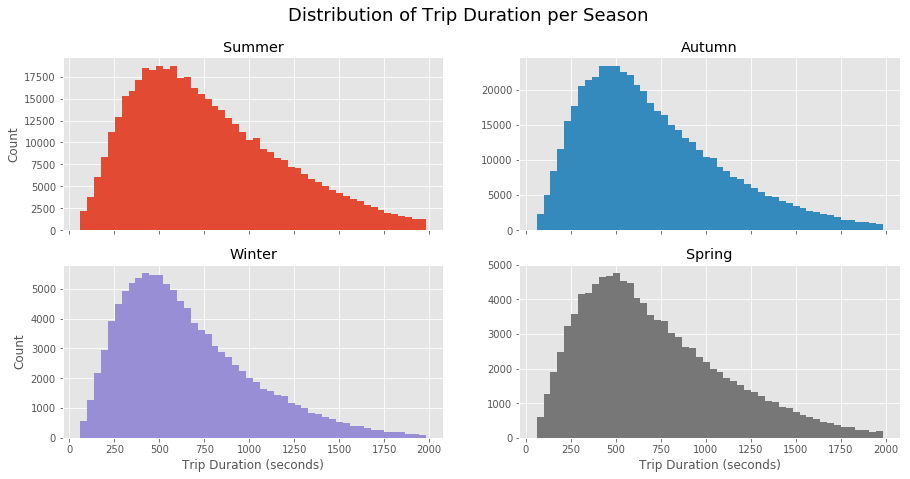

In [170]:
fig, ax = plt.subplots(2,2, sharex=True)

ax[0][0].hist(df[df.season=='summer']['trip_duration_seconds'], bins=50)
ax[0][1].hist(df[df.season=='autumn']['trip_duration_seconds'], bins=50, color='C1')
ax[1][0].hist(df[df.season=='winter']['trip_duration_seconds'], bins=50, color='C2')
ax[1][1].hist(df[df.season=='spring']['trip_duration_seconds'], bins=50, color='C3')

ax[0][0].set_title("Summer")
ax[0][1].set_title("Autumn")
ax[1][0].set_title("Winter")
ax[1][1].set_title("Spring")

plt.suptitle("Distribution of Trip Duration per Season", fontsize=18)
ax[0][0].set_ylabel("Count")
ax[1][0].set_ylabel("Count")
ax[1][0].set_xlabel("Trip Duration (seconds)")
ax[1][1].set_xlabel("Trip Duration (seconds)")
plt.show()

In [171]:
desc = {'Summer': df[df.season == 'summer']['trip_duration_seconds'].describe().round(1),
        'Autumn': df[df.season == 'autumn']['trip_duration_seconds'].describe().round(1),
       'Winter': df[df.season == 'winter']['trip_duration_seconds'].describe().round(1),
       'Spring': df[df.season == 'spring']['trip_duration_seconds'].describe().round(1)}
pd.DataFrame(desc)

,Summer,Autumn,Winter,Spring
count,460595.0,511534.0,110454.0,104644.0
mean,773.4,708.3,655.8,710.1
std,412.2,388.9,362.7,393.6
min,60.0,60.0,60.0,60.0
25%,453.0,412.0,382.0,409.0
50%,699.0,629.0,580.0,630.0
75%,1036.0,937.0,861.0,947.0
max,1982.0,1982.0,1982.0,1982.0


The shapes of the distribution for each season are nearly identical. Notice, though, that we are using a unique y-axis for each graph, while keeping the same x-axis throughout.

We can still see that the season does to some extent affect trip duration: the mean trip duration during winter is 656, or 11 minutes, while the mean for summer is 773 minutes, or 13 minutes. We cannot say for sure that this is a significant difference, it may just be caused by the specific data we happen to have. Recall also that we removed proportionately more values from winter and spring. If we had kept those records, we could potentially have more similar means across all seasons.

Let's also take a look at trip distance:

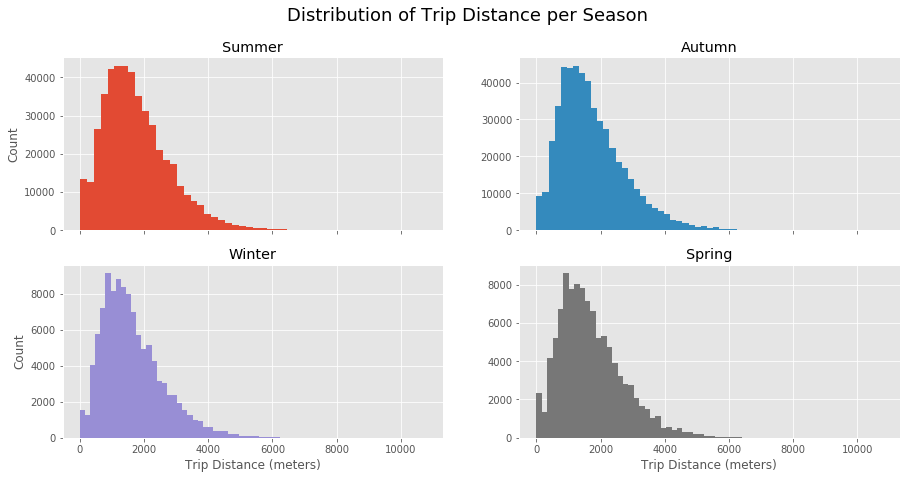

In [172]:
fig, ax = plt.subplots(2,2, sharex=True)

ax[0][0].hist(df[df.season=='summer']['trip_distance'], bins=50)
ax[0][1].hist(df[df.season=='autumn']['trip_distance'], bins=50, color='C1')
ax[1][0].hist(df[df.season=='winter']['trip_distance'], bins=50, color='C2')
ax[1][1].hist(df[df.season=='spring']['trip_distance'], bins=50, color='C3')

ax[0][0].set_title("Summer")
ax[0][1].set_title("Autumn")
ax[1][0].set_title("Winter")
ax[1][1].set_title("Spring")

plt.suptitle("Distribution of Trip Distance per Season", fontsize=18)
ax[0][0].set_ylabel("Count")
ax[1][0].set_ylabel("Count")
ax[1][0].set_xlabel("Trip Distance (meters)")
ax[1][1].set_xlabel("Trip Distance (meters)")
plt.show()

In [173]:
desc = {'Summer': df[df.season == 'summer']['trip_distance'].describe().round(1),
        'Autumn': df[df.season == 'autumn']['trip_distance'].describe().round(1),
       'Winter': df[df.season == 'winter']['trip_distance'].describe().round(1),
       'Spring': df[df.season == 'spring']['trip_distance'].describe().round(1)}
pd.DataFrame(desc)

,Summer,Autumn,Winter,Spring
count,460595.0,511534.0,110454.0,104644.0
mean,1750.3,1727.4,1640.7,1702.8
std,1038.6,1031.5,960.6,1003.2
min,0.0,0.0,0.0,0.0
25%,997.2,977.4,932.9,954.2
50%,1577.3,1527.2,1454.8,1524.9
75%,2318.5,2278.1,2159.6,2272.4
max,10773.6,9477.0,7979.8,8423.3


Again, we do not notice any significant differences between the distributions, but we can still see that trips are on average shorter during winter and spring compared to summer and autumn, though not by much. Looking at the 3rd quartile and maximum values, we can observe how very long trips are more frequent during summer and autumn months.

As has become tradition, we can take a peek at whether there's a difference in the average speed of trips across the seasons:

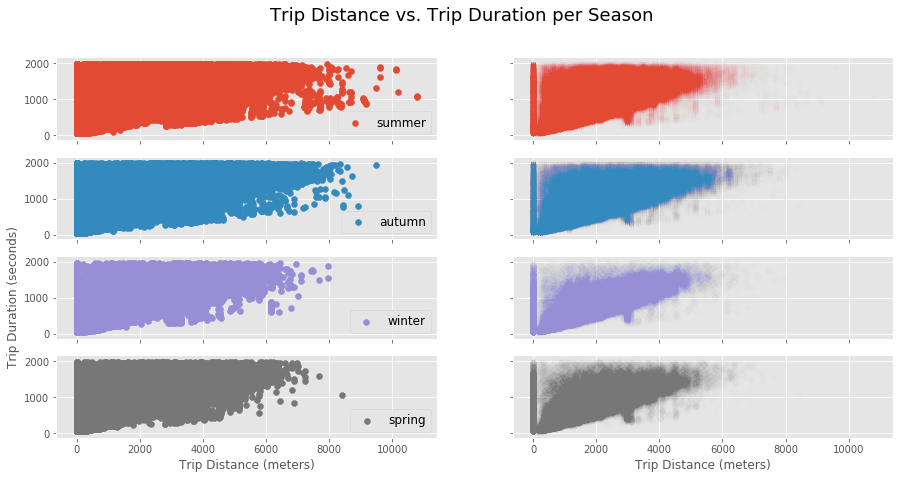

In [186]:
seasons = ['summer', 'autumn', 'winter', 'spring']
# Since there are approximately 5 times more observations in summer and autumn, we will scale the
# transparency of the scatterplots appropriately
alphas=[0.002, 0.002, 0.01, 0.01]

fig, ax = plt.subplots(4,2, sharey=True, sharex=True)

for i in range(4):
    ax[i][0].scatter(x=df[df.season == seasons[i]]['trip_distance'],
                     y=df[df.season==seasons[i]]['trip_duration_seconds'],
                    color = 'C{}'.format(i), label=seasons[i])
    ax[i][1].scatter(x=df[df.season == seasons[i]]['trip_distance'],
                    y = df[df.season==seasons[i]]['trip_duration_seconds'],
                    color = 'C{}'.format(i), label=seasons[i], alpha=alphas[i])


    
plt.suptitle("Trip Distance vs. Trip Duration per Season", fontsize=18)
ax[3][0].set_xlabel("Trip Distance (meters)")
ax[3][1].set_xlabel("Trip Distance (meters)")
ax[2][0].set_ylabel("Trip Duration (seconds)")
ax[0][0].legend(fontsize=12, loc='lower right')
ax[1][0].legend(fontsize=12, loc='lower right')
ax[2][0].legend(fontsize=12, loc='lower right')
ax[3][0].legend(fontsize=12, loc='lower right')
plt.show()

Since the distributions for trip duration and distance were very similar across all seasons, it is no surprise that their relationships are also similar. Still, we can once more notice how long distance trips are more common during summer and autumn. Trips starting and ending at the same station is a phenomenon that can be observed during all seasons.

In the scatterplots with transparent points we have adjusted the transparency of points to account for the differences in the number of observations per season: namely, we have made the points on the winter and spring plots 5 times more opaque as there are approximately 5 times fewer points on those plots compared to summer and autumn. So it might seem as if trips with very slow average speeds are less common during winter and spring. However, it is also possible that this is just an effect of how we decided to choose the transparency despite our best efforts to make it as fair as possible.

Now, let's dive into the weather data. Recall that we have columns `mean_temp`, representing the mean temperature in degrees Celcius of the day the trip took place, and `precipitation`, representing whether there was any precipitation on the day of the trip. First, let's look at how these two dimensions affect trip duration.

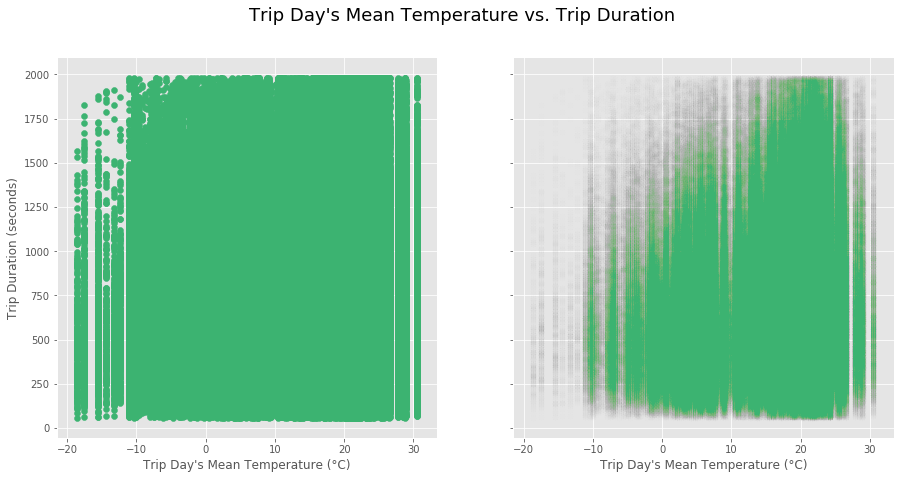

In [245]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.mean_temp, y=df.trip_duration_seconds, color='mediumseagreen')
ax[1].scatter(x=df.mean_temp, y=df.trip_duration_seconds, alpha=0.002, color='mediumseagreen')

plt.suptitle("Trip Day's Mean Temperature vs. Trip Duration", fontsize=18)
ax[0].set_xlabel("Trip Day's Mean Temperature (°C)")
ax[1].set_xlabel("Trip Day's Mean Temperature (°C)")
ax[0].set_ylabel("Trip Duration (seconds)")
plt.show()

We can immediatelly notice how trips are much shorter during days with a very low mean temperature. As the daily mean temperature increases, so do trip durations, until around 25°C, where trip durations start dropping again. 

Recall how when we plotted the countwise distribution of trips' daily mean temperature, we saw a distribution with two dominant modes: one centered around 5°C and the other around 20°C. The same bimodality can be noticed on the right graph: long duration trips become more frequent at around 5°C, but then drop until around 10°C only to rise again until 20°C. There are two possible explanations for this phenomenon: either it is just a cause of how the underlying data for trips' daily mean temperature distributes and hence makes those temperature ranges seem more dominant, or Bike Share users actually have two 'favourite' temperatures to ride a bike, and also embark on longer journeys during such days.

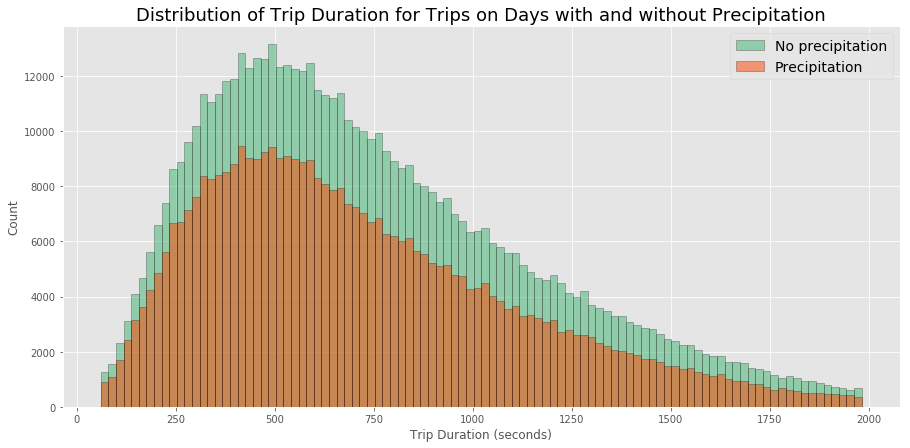

In [247]:
plt.hist(df[df.precipitation == False]['trip_duration_seconds'], bins=100, alpha=0.5, edgecolor='black',
        color='mediumseagreen', label='No precipitation')    
plt.hist(df[df.precipitation == True]['trip_duration_seconds'], bins=100, alpha=0.5, edgecolor='black',
        color='orangered', label='Precipitation')

plt.title("Distribution of Trip Duration for Trips on Days with and without Precipitation", fontsize=18)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

In [252]:
desc = {'No precipitation': df[df.precipitation == False]['trip_duration_seconds'].describe().round(1),
        'Precipitation': df[df.precipitation == True]['trip_duration_seconds'].describe().round(1),}
pd.DataFrame(desc)

,No precipitation,Precipitation
count,591470.0,414015.0
mean,743.6,719.4
std,404.4,394.2
min,60.0,60.0
25%,431.0,417.0
50%,665.0,640.0
75%,992.0,956.0
max,1982.0,1982.0


The distributions for trips on days with and without precipitation are shape-wise quite similar. It appears that the distribution for trips on days with precipitation is simply shifted to the left by a small amount, this can be seen by noticing that the quartile values have very similar differences between them.

Now, a look at trip distance:

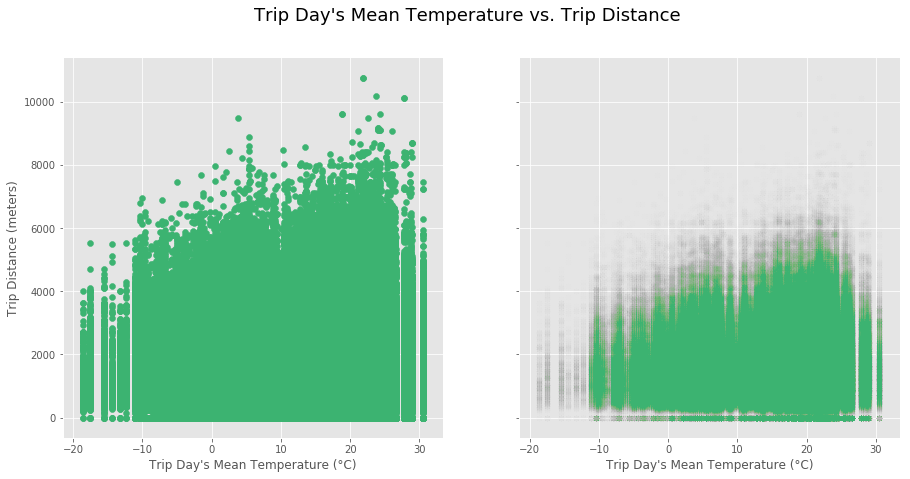

In [250]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.mean_temp, y=df.trip_distance, color='mediumseagreen')
ax[1].scatter(x=df.mean_temp, y=df.trip_distance, alpha=0.002, color='mediumseagreen')

plt.suptitle("Trip Day's Mean Temperature vs. Trip Distance", fontsize=18)
ax[0].set_xlabel("Trip Day's Mean Temperature (°C)")
ax[1].set_xlabel("Trip Day's Mean Temperature (°C)")
ax[0].set_ylabel("Trip Distance (meters)")
plt.show()

These results are similar to what we saw for trip duration: generally, trip distance and the trip's day mean temperature have a positive association. We can again notice the two modes centered around 5°C and 20°C, leaving us with the same two possible explanations as before. Because we observed this when looking at both trip distance and trip duration, it appears to be more likely that this phenomenon is caused by how trip frequency distributes depending on the trip's day mean temperature, rather than the temperature having a direct impact on duration and distance.

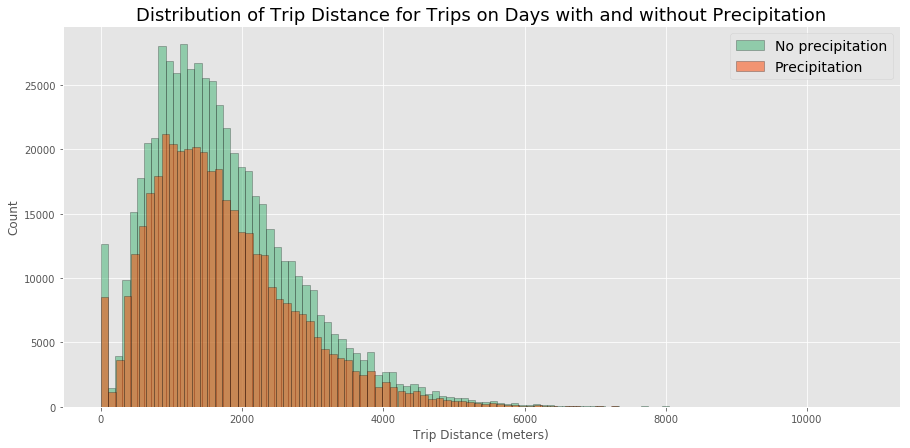

In [254]:
plt.hist(df[df.precipitation == False]['trip_distance'], bins=100, alpha=0.5, edgecolor='black',
        color='mediumseagreen', label='No precipitation')    
plt.hist(df[df.precipitation == True]['trip_distance'], bins=100, alpha=0.5, edgecolor='black',
        color='orangered', label='Precipitation')

plt.title("Distribution of Trip Distance for Trips on Days with and without Precipitation", fontsize=18)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

In [253]:
desc = {'No precipitation': df[df.precipitation == False]['trip_distance'].describe().round(1),
        'Precipitation': df[df.precipitation == True]['trip_distance'].describe().round(1),}
pd.DataFrame(desc)

,No precipitation,Precipitation
count,591470.0,414015.0
mean,1741.9,1706.8
std,1040.2,1012.9
min,0.0,0.0
25%,983.1,969.6
50%,1546.9,1524.9
75%,2303.2,2257.7
max,10193.4,10773.6


Just like for trip duration, we can see that the distribution for trips on days with precipitation is ever so slightly nudged to the left when we look at its quartile and mean values.

# Conclusion

In this report, we defined trip length in two ways: by its duration in seconds, and by the straight line distance between its start and stop stations.

The raw data came with many flaws, and it is possible that there are many more that were left unnoticed. We removed trips with absurd durations and average speeds, and also trips for which station name inconsistencies made it impossible to compute trip distance. In total, we reduced the dataset by around 40%, down to 1.2 million observations.

We noticed a positive association between our two definitions of trip length. Very roughly it seemed like the relationship is exponential, but the data has a huge amount of variance.

When looking at how Toronto Bike Share members compare to casual users using a temporary pass, it appeared as if casual users like to 'get their money's worth' by embarking on trips that had significantly longer durations. The same could not be said about trip distance, however: there did not appear to be any noticeable difference there. We also noticed that to some extent, casual users frequently took more time to cover the same amount of distance, reinforcing the idea of casual users making sure to fully use what they paid for. The large majority of trips were completed by members.

There were nearly 5 times more trips completed during summer and autumn months compared to winter and spring. However, when looking at the distributions of our two definitions of trip length relative to the seasons, we did not notice too many differences. Still, one could notice how trips during summer both took more time and were longer in distance compared to winter, but these differences could be insignificant.

We scraped data from Canada's historical climate database for each day in the scope of this report: July 1st 2016 - December 31st 2017. We joined this data to our trip dataset, showing the mean temperature for the day each trip was started on, and whether there was any precipitation on that day. Looking at how the mean temperature statistic distributed, we saw that there were two modes where trips were more frequent. When we looked at how temperature related to trip length, we saw the similar bimodal phenomenon for both definitions, however we can't really make a conclusion on what is truly going on. Looking at precipitation, we saw how the distributions regarding trip length were nudged slightly to the left for trips on days with precipitation.

# Limitations

Several compormises and generalizations had to be made during this report. We reduced the original Bike Share dataset by about 40%, the majority of which was caused by inconsistencies in bike station names. If we were to fix these issues, we could be more confident in our analysis as we would be using the entire data. As we saw, depending on which categories we looked at, we had sometimes disproportionately taken more data away from certain subgroups, which could have skewed our analysis.

To speed up the computation, we significantly reduced the data dimension for precipitation data, which is likely the reason why our analysis on precipitation barely found anything interesting or unusual. We could have a lot more insight with a more sophisticated approach to how we use the precipitation data.

We defined trip distance as the distance between the trip's start and end stations 'as the crow flies', which is a very simplified definition. We unfortunately don't have precise bike tracking data, and finding the actual shortest path between two stations is an incredibly complex task. Unless the stations happened to be on the same straight street, the distance we calculated would not represent the actual distance the cyclist covered. If we had the opportunity for a better measurement of distance, our analysis could be a lot more significant.

Throughout this report we relied on visualizations and summary statistics to analyze the data, which on many occasions meant that we couldn't conclude if things were one way or the other. Many of these questions could be answered by analysing it with a more complex method, suggestions for which are provided in the following extensions section.

# Extensions

This section summarises some of the questions that were left open throughout the report, and tries to suggest potential ways of answering them.

Were we given tremendous amounts of computing power, one could come up with a solution to compute the shortest realistic path a cyclist could have taken to go from the start station to the end. This way we could compute an expected travel time, and compare it to the actual duration, which could provide many interesting insights.

With some meteorological research, one could come up with a more sophisticated way to use the precipitation data. Toronto is a big city, so somehow combining data from different parts of the city could prove to be more accurate. Also, it is possible that on some day it only rained during the night, but it was a perfectly fine day during daytime when we would expect most cyclist to use the Bike Share service - our classification would have got such a day in the completely wrong category. So, finding more precise hourly data could be very insightful.

When we visualized the relationship between distance travelled and the time it took for that, we noticed an interesting outsticking dense cluster of points with a distance of around 3000 meters and a duration of 500 seconds. We guessed that this might be because of a very popular route between two stations. One could look into what the most popular stations/routes are, and see if the trip durations and distances match for such stations. Or perhaps something completely different is going on.

We saw how trip frequency distributed bimodaly when looking at the trip's day mean temperature, and noticed the same pattern when looking at trip duration and distance. It seemed probable that the actual relationship exists between the mean temperature and frequency, and that the phenomena when looking at duration and distance were just byproducts of this relationship. This, however, was just a guess, and it could be checked by hypothesis testing it.